In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from simulation_utils import *
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances, DistanceMetric, auc, f1_score, mutual_info_score
from sklearn.metrics.pairwise import manhattan_distances, cosine_distances
from sklearn.cluster import KMeans
import scipy.stats as stat
from scipy.optimize import minimize
import itertools
# import ipyparallel as ipp
from collections import defaultdict
import pymc as pm
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import jensenshannon
import matplotlib.animation as animation


In [2]:
graph = create_adjacency_matrix_for_modular_graph(15, 3, [5, 5, 5], [(0, 14), (4, 5), (9, 10)], [0, 4, 5, 9, 10, 14])


In [9]:
walk_lenghts = [1, 1000]
num_experiments = 50
criteria = np.linspace(0.7, 0.9, 10)

old_new_labels = np.tile(np.repeat(['old', 'new'], 15), num_experiments*len(criteria)*len(walk_lenghts))
all_response_labels = []
all_true_labels = []
all_node_types = np.tile(np.array(['boundary', 'nonboundary', 'nonboundary', 'nonboundary', 'boundary', 'boundary', 'nonboundary', 'nonboundary', 'nonboundary', 'boundary', 'boundary', 'nonboundary', 'nonboundary', 'nonboundary', 'boundary'] + ['new']*15), num_experiments*len(criteria)*len(walk_lenghts))
for walk_length in walk_lenghts:
    for crit in criteria:
        for exp in range(num_experiments):
            walk = random_walk(graph, walk_length, 1000).astype(int)
            SR, _ = run_SR(walk, graph)
            entropies = np.array([-np.sum(SR[node]*np.log(SR[node])) for node in range(graph.shape[0])])

            old_stimuli = np.random.uniform(size = (15, 10))
            new_stimuli = np.random.uniform(size = (15, 10))

            all_test_stimuli = np.row_stack((old_stimuli, new_stimuli))
            memory_strength = entropies



            distance_matrix = euclidean_distances(all_test_stimuli, old_stimuli)
            similarity_matrix = np.exp(-distance_matrix)
            activation_matrix = np.dot(similarity_matrix, memory_strength)
            prob_activation = activation_matrix/np.max(activation_matrix)
            all_response_labels.extend(['new' if pa < crit else 'old' for pa in prob_activation])




In [10]:
recog_df = pd.DataFrame({'Experiment': np.repeat(np.arange(num_experiments), 30*len(criteria)*len(walk_lenghts)),
                         'walk_length': np.repeat(walk_lenghts, num_experiments*30*len(criteria)),
                         'criterion': np.tile(np.repeat(criteria, 30*num_experiments), len(walk_lenghts)),
                         'old_new_labels': old_new_labels,
                         'node_types': all_node_types,
                         'response': all_response_labels,                         
                         })
recog_df['Recognition accuracy'] = 1
recog_df.loc[recog_df.old_new_labels != recog_df.response, 'Recognition accuracy'] = 0

C:\Users\tejas\AppData\Local\Temp\ipykernel_24044\219811365.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.axes[0][col].set_xticklabels(['{:.2f}'.format(float(t.get_text())) for t in ax.axes[0][col].get_xticklabels()])
C:\Users\tejas\AppData\Local\Temp\ipykernel_24044\219811365.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.axes[0][col].set_xticklabels(['{:.2f}'.format(float(t.get_text())) for t in ax.axes[0][col].get_xticklabels()])


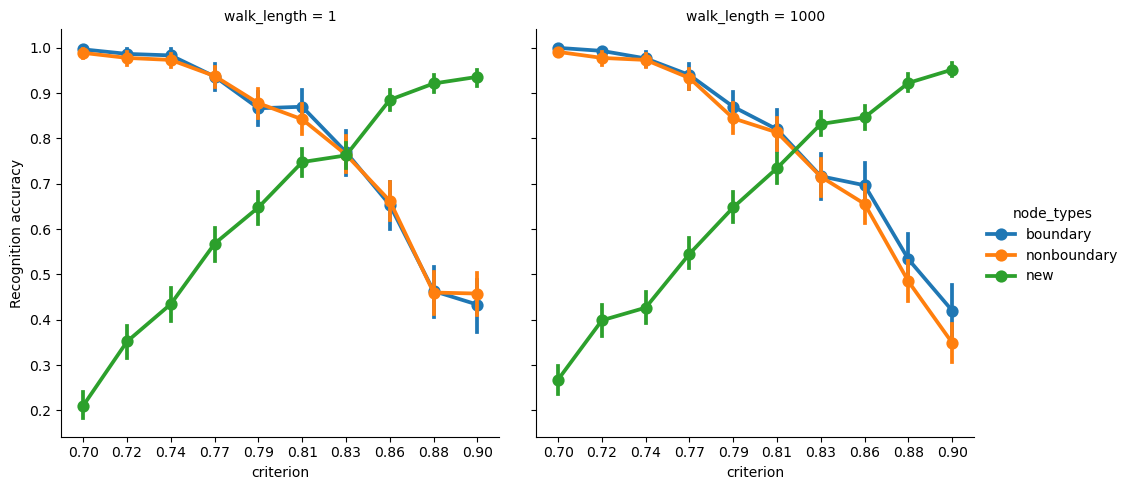

In [12]:
ax = sns.catplot(x = 'criterion', hue = 'node_types', y = 'Recognition accuracy', col = 'walk_length',
                 data = recog_df, kind = 'point')
for col in range(2):
    ax.axes[0][col].set_xticklabels(['{:.2f}'.format(float(t.get_text())) for t in ax.axes[0][col].get_xticklabels()])
plt.savefig('figures/recog_memory_with_criterion.png', dpi = 300, transparent = True)

In [161]:
num_experiments = 50
criteria = np.linspace(0.7, 0.9, 10)

old_new_labels = np.tile(np.repeat(['old', 'new'], 15), num_experiments*len(criteria))
all_response_labels = []
all_true_labels = []
all_node_types = np.tile(np.array(['boundary', 'nonboundary', 'nonboundary', 'nonboundary', 'boundary', 'boundary', 'nonboundary', 'nonboundary', 'nonboundary', 'boundary', 'boundary', 'nonboundary', 'nonboundary', 'nonboundary', 'boundary'] + ['new']*15), num_experiments*len(criteria))
for crit in criteria:
    for exp in range(num_experiments):
        walk = random_walk(graph, 1, 1000).astype(int)
        SR, _ = run_SR(walk, graph)
        entropies = np.array([-np.sum(SR[node]*np.log(SR[node])) for node in range(graph.shape[0])])

        old_stimuli = np.random.uniform(size = (15, 10))
        new_stimuli = np.random.uniform(size = (15, 10))

        all_test_stimuli = np.row_stack((old_stimuli, new_stimuli))
        memory_strength = entropies



        distance_matrix = euclidean_distances(all_test_stimuli, old_stimuli)
        similarity_matrix = np.exp(-distance_matrix)
        activation_matrix = np.dot(similarity_matrix, memory_strength)
        prob_activation = activation_matrix/np.max(activation_matrix)
        all_response_labels.extend(['new' if pa < crit else 'old' for pa in prob_activation])




In [162]:
recog_df = pd.DataFrame({'Experiment': np.repeat(np.arange(num_experiments), 30*len(criteria)),
                         'criterion': np.repeat(criteria, 30*num_experiments),
                         'old_new_labels': old_new_labels,
                         'node_types': all_node_types,
                         'response': all_response_labels,                         
                         })
recog_df['Recognition accuracy'] = 1
recog_df.loc[recog_df.old_new_labels != recog_df.response, 'Recognition accuracy'] = 0

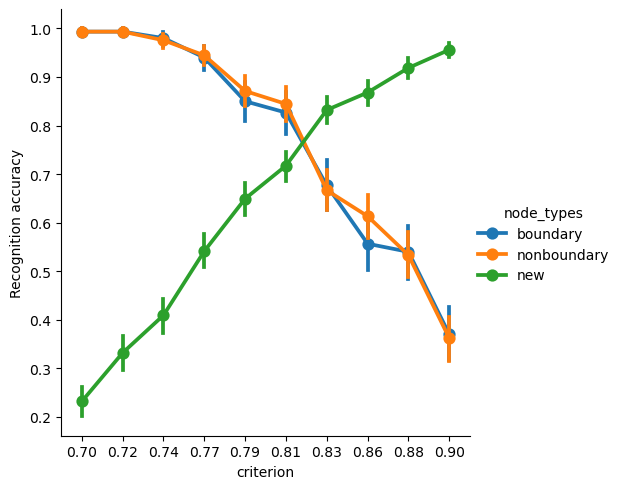

In [163]:
ax = sns.catplot(x = 'criterion', hue = 'node_types', y = 'Recognition accuracy', data = recog_df, kind = 'point')
ax.set_xticklabels(['{:.2f}'.format(float(t.get_text())) for t in ax.axes[0][0].get_xticklabels()])


In [ ]:
def get_encoded(store_prob_alpha, store_prob_beta, encode_noise, stim_stream, obj_cat_feature_matrix, context_boost = False, node_entropy = None):
    encoder = np.zeros((len(stim_stream), obj_cat_feature_matrix.shape[1]))
    # forgetting_rate = 0.05
    # encoding_rate = 0.9
    if not context_boost:
        for i, stim in enumerate(stim_stream):
            for feature in range(obj_cat_feature_matrix.shape[1]):
                store_prob = np.random.beta(store_prob_alpha, store_prob_beta)
                acc_prob = np.random.beta(store_prob_alpha, store_prob_beta)

                if np.random.binomial(1, store_prob):
                    if np.random.binomial(1, acc_prob):
                        encoder[i][feature] = obj_cat_feature_matrix[stim][feature] 
                    else:
                        encoder[i][feature] = obj_cat_feature_matrix[stim][feature] + np.random.normal(obj_cat_feature_matrix[stim][feature], encode_noise)
                else:
                    encoder[i][feature] = 0
    else:
        for i, stim in enumerate(stim_stream):
            for feature in range(obj_cat_feature_matrix.shape[1]):
                store_prob = np.random.beta(store_prob_alpha*node_entropy[stim], store_prob_beta/node_entropy[stim])
                acc_prob = np.random.beta(store_prob_alpha*node_entropy[stim], store_prob_beta/node_entropy[stim])

                if np.random.binomial(1, store_prob):
                    if np.random.binomial(1, acc_prob):
                        encoder[i][feature] = obj_cat_feature_matrix[stim][feature] 
                    else:
                        encoder[i][feature] = obj_cat_feature_matrix[stim][feature] + np.random.normal(obj_cat_feature_matrix[stim][feature], encode_noise)
                else:
                    encoder[i][feature] = 0
        

    return encoder


# Distance Simulations

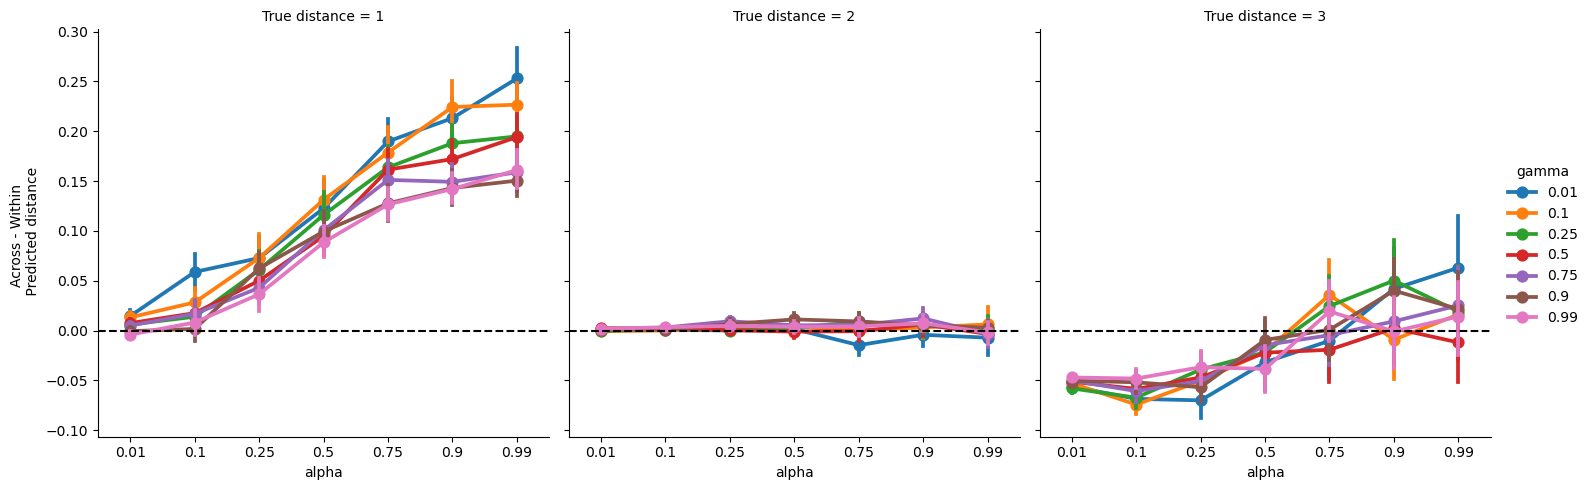

In [86]:
distances = pd.read_csv('simulation_results/2moduledist_SR_distances.csv').drop(['Unnamed: 0', "walk_length", "model", "node"], axis = 1)
distances.rename(columns={"entropy distance (2)": "2", "entropy distance (3)": "3", "entropy distance (1)": "1"}, inplace = True)
# # distances['param_a'] = distances.param_b.astype('category')
distances['param_b'] = distances.param_b.astype('category')
distances_melt = distances.melt(id_vars=["iteration", "param_a", "param_b"], 
                                var_name= "True distance",
                                value_vars=["1", "2", "3"], 
                                value_name="distance_diff").reset_index(drop = True)
distances_melt.rename(columns={"param_a": "alpha", "param_b": "gamma"}, inplace = True)

g = sns.catplot(hue = 'gamma', y = 'distance_diff', x = 'alpha', col = 'True distance', 
            kind = 'point', 
            data = distances_melt)

g.axes[0][0].set_ylabel("Across - Within \n Predicted distance")

g.axes[0][0].axhline(y = 0, color = 'black', ls = '--')
g.axes[0][1].axhline(y = 0, color = 'black', ls = '--')
g.axes[0][2].axhline(y = 0, color = 'black', ls = '--')
plt.savefig('figures/distance_predictions.png', dpi = 300, transparent = True)


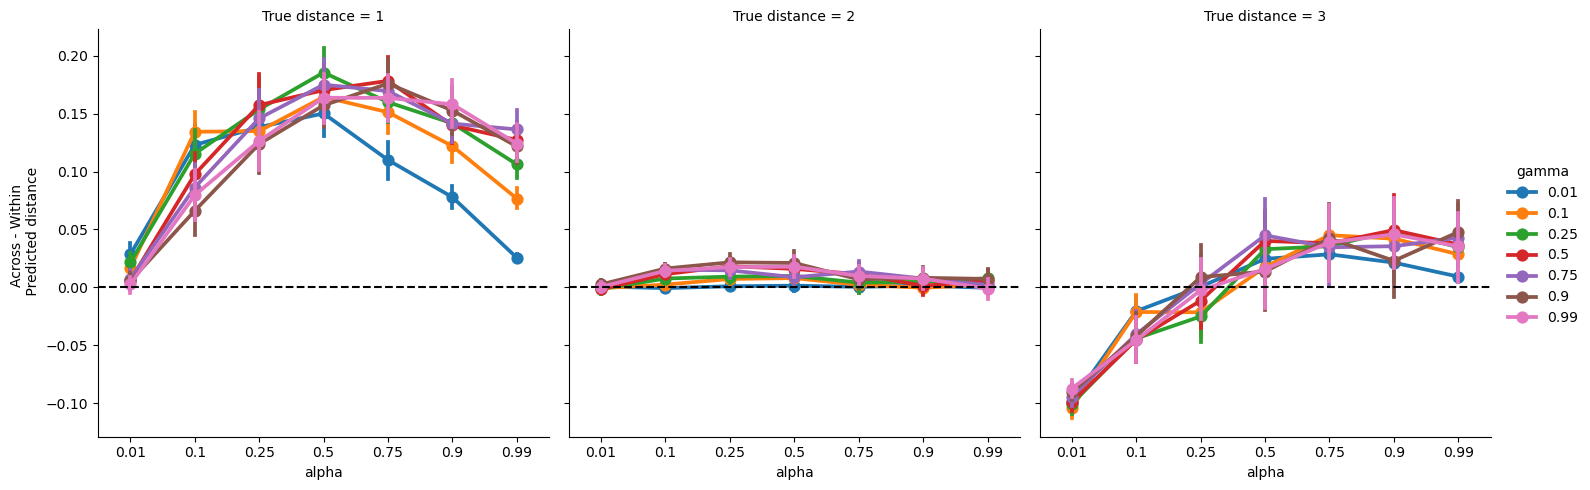

In [87]:
distances = pd.read_csv('simulation_results/2moduledist_SR_distances_entropyboost.csv').drop(['Unnamed: 0', "walk_length", "model", "node"], axis = 1)
distances.rename(columns={"entropy distance (2)": "2", "entropy distance (3)": "3", "entropy distance (1)": "1"}, inplace = True)

# # distances['param_a'] = distances.param_b.astype('category')
distances['param_b'] = distances.param_b.astype('category')
distances_melt = distances.melt(id_vars=["iteration", "param_a", "param_b"], 
                                var_name= "True distance",
                                value_vars=["1", "2", "3"], 
                                value_name="distance_diff").reset_index(drop = True)
distances_melt.rename(columns={"param_a": "alpha", "param_b": "gamma"}, inplace = True)

g = sns.catplot(hue = 'gamma', y = 'distance_diff', x = 'alpha', col = 'True distance', 
            kind = 'point', 
            data = distances_melt)
g.axes[0][0].set_ylabel("Across - Within \n Predicted distance")

g.axes[0][0].axhline(y = 0, color = 'black', ls = '--')
g.axes[0][1].axhline(y = 0, color = 'black', ls = '--')
g.axes[0][2].axhline(y = 0, color = 'black', ls = '--')

plt.savefig('figures/distance_predictions_entropyboost.png', dpi = 300, transparent = True)


In [13]:
two_module_dist_graph = create_adjacency_matrix_for_modular_graph(10, 2, [5, 5], [(4, 5)], [4, 5], 
                                                                  [(0, 4), (4, 1), (0, 2), (0, 3), 
                                                                   (9, 5), (5, 8), (6, 9), (7, 9)                                                             
                                                                  ])


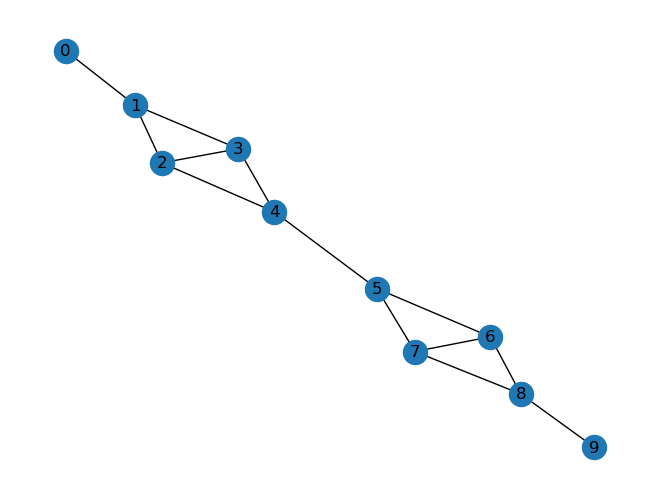

In [19]:
plot_graph(two_module_dist_graph, 'figures/two_module_graph.png')

<Axes: >

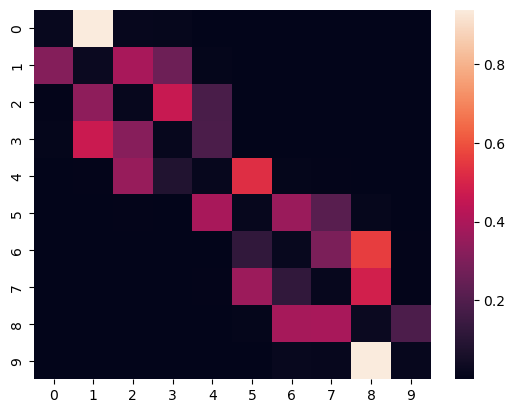

In [23]:
walk = random_walk(two_module_dist_graph, 1000, 1000)
SR_matrix = run_SR(walk, two_module_dist_graph)[0]
sns.heatmap(SR_matrix)


In [81]:
compute_node_entropies

<function simulation_utils.compute_node_entropies(params)>

In [70]:
param_iterator = itertools.product(np.arange(50), [0.01, 0.1, 0.25, 0.5, 0.75, 0.9], [0.01, 0.1, 0.25, 0.5, 0.75, 0.9])
params = [i for i in param_iterator]
all_dist_df = []
for p in params:
    walk = random_walk(two_module_dist_graph, 1000, 1000)
    SR_matrix = run_SR(walk, two_module_dist_graph, alpha = p[1], gamma = p[2])[0]

    within = np.array([[4, 0], [5, 9], [4, 1], [5, 8], [4, 2], [4, 3], [5, 7], [5, 6]])
    between = np.array([[4, 8], [5, 1], [4, 7], [4, 6], [5, 2], [5, 3], [4, 5], [5, 4]])
    between_distance = np.array([3, 3, 2, 2, 2, 2, 1, 1])
    within_distance = np.array([3, 3, 2, 2, 1, 1, 1, 1])
    within_prob = np.array([SR_matrix[within[i][0], within[i][1]] for i in range(within.shape[0])])
    between_prob = np.array([SR_matrix[between[i][0], between[i][1]] for i in range(between.shape[0])])
    within_df = pd.DataFrame({'within_distance': within_distance, 'within_prob': within_prob}).groupby('within_distance').mean().reset_index()
    between_df = pd.DataFrame({'between_distance': between_distance, 'between_prob': between_prob}).groupby('between_distance').mean().reset_index()
    dist_df = pd.merge(left=within_df, right=between_df, left_on='within_distance', right_on='between_distance')
    dist_df['alpha'] = p[1]
    dist_df['gamma'] = p[2]
    dist_df['iteration'] = p[0]
    all_dist_df.append(dist_df)


In [79]:
SR_matrix[within[i][0]]

array([5.79598872e-04, 8.50115206e-02, 6.64035437e-01, 2.00298646e-02,
       2.29794336e-01, 5.41744381e-04, 3.68710677e-06, 2.88093076e-06,
       9.29856661e-07, 2.59629219e-10])

In [ ]:
all_dist_df = pd.concat(all_dist_df)
all_dist_df['prob_diff'] = all_dist_df['between_prob'] - all_dist_df['within_prob']
all_dist_df

Text(33.84096875, 0.5, 'Between - Within \n Activation Difference')

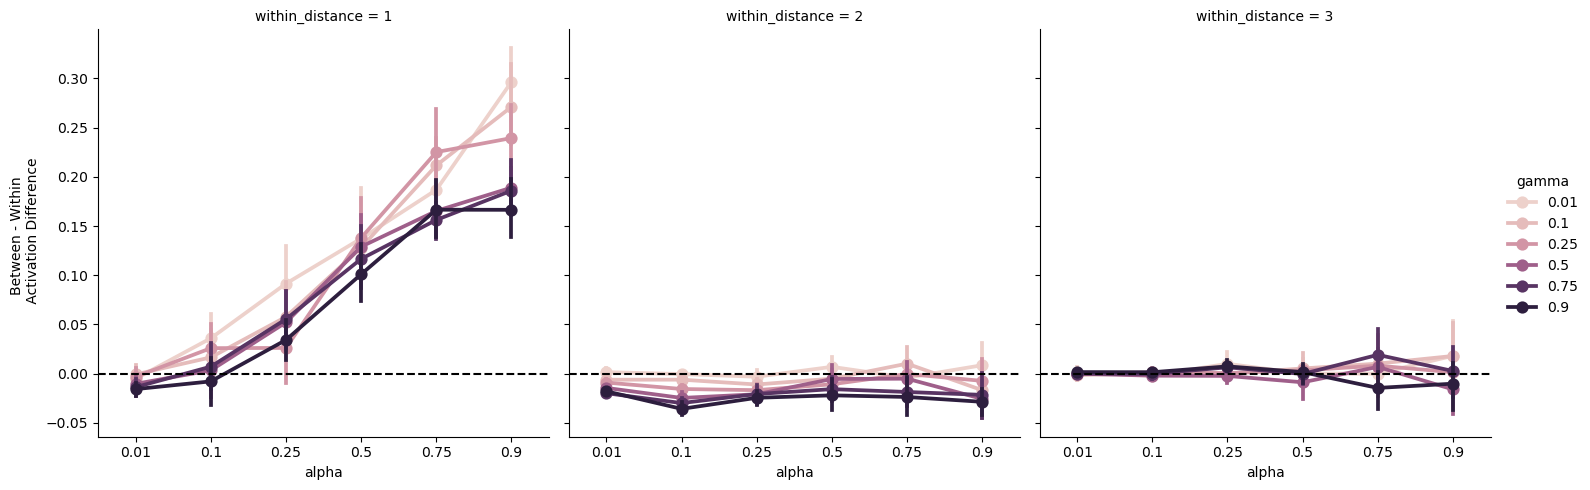

In [77]:
g = sns.catplot(y = 'prob_diff', 
            x = 'alpha', hue = 'gamma', col = 'within_distance',
            data = all_dist_df,
            kind = 'point')
for i in range(3):
    g.axes[0][i].axhline(y = 0, ls = '--', color = 'black')
g.axes[0][0].set_ylabel('Between - Within \n Activation Difference')

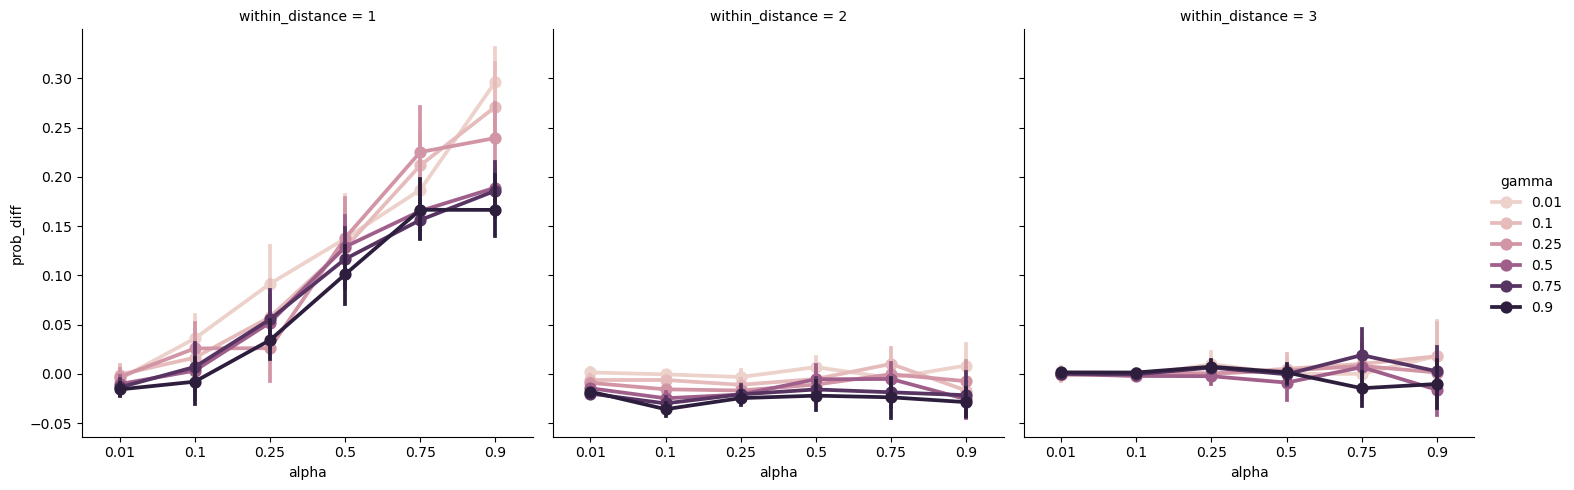

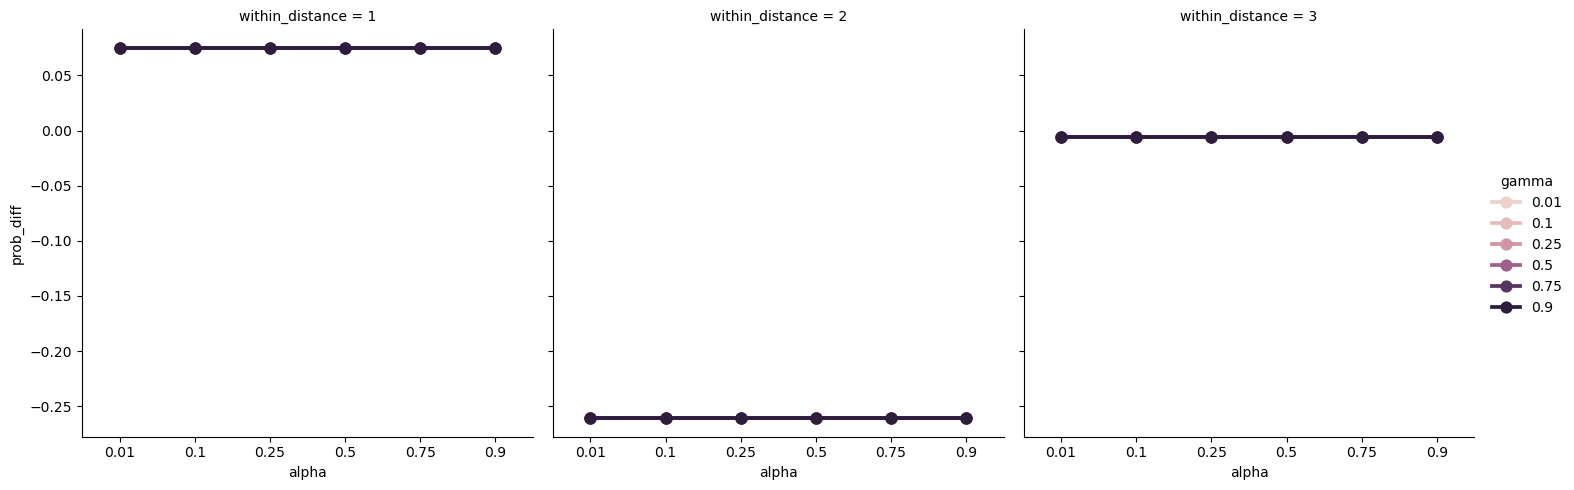

In [ ]:
distances = pd.read_csv('simulation_results/2moduledist_SR_distances.csv').drop(['Unnamed: 0', "walk_length", "model", "node"], axis = 1)
distances.rename(columns={"entropy distance (2)": "2", "entropy distance (3)": "3", "entropy distance (1)": "1"}, inplace = True)
# # distances['param_a'] = distances.param_b.astype('category')
distances['param_b'] = distances.param_b.astype('category')
distances_melt = distances.melt(id_vars=["iteration", "param_a", "param_b"], 
                                var_name= ["True distance"],
                                value_vars=["1", "2", "3"], 
                                value_name="distance_diff").reset_index(drop = True)
distances_melt.rename(columns={"param_a": "alpha", "param_b": "gamma"}, inplace = True)

g = sns.catplot(hue = 'gamma', y = 'distance_diff', x = 'alpha', col = 'True distance', 
            kind = 'point', 
            data = distances_melt)

g.axes[0][0].set_ylabel("Across - Within \n Predicted distance")

g.axes[0][0].axhline(y = 0, color = 'black', ls = '--')
g.axes[0][1].axhline(y = 0, color = 'black', ls = '--')
g.axes[0][2].axhline(y = 0, color = 'black', ls = '--')
